<a href="https://colab.research.google.com/github/chauhan231405/bigdataLAB/blob/main/spark3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=1f60c3556e730747feafb0f3086ca3a55785ff1756e855d5a526be4d1d9b889d
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
from pyspark import SparkConf,SparkContext
conf=SparkConf().setAppName('abc').setMaster('local') #
sc=SparkContext(conf=conf)
sc.setLogLevel('ERROR')
from pyspark.sql import SparkSession
spark=SparkSession.builder.appName('abc').config('','').getOrCreate()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df = spark.read.csv('/content/iris.csv', header=None, inferSchema=True)
df.show(5,0)

+---+---+---+---+-----------+
|_c0|_c1|_c2|_c3|_c4        |
+---+---+---+---+-----------+
|5.1|3.5|1.4|0.2|Iris-setosa|
|4.9|3.0|1.4|0.2|Iris-setosa|
|4.7|3.2|1.3|0.2|Iris-setosa|
|4.6|3.1|1.5|0.2|Iris-setosa|
|5.0|3.6|1.4|0.2|Iris-setosa|
+---+---+---+---+-----------+
only showing top 5 rows



In [ ]:
df.columns

['_c0', '_c1', '_c2', '_c3', '_c4']

In [ ]:
df.count()

150

In [ ]:
df.printSchema()

root
 |-- _c0: double (nullable = true)
 |-- _c1: double (nullable = true)
 |-- _c2: double (nullable = true)
 |-- _c3: double (nullable = true)
 |-- _c4: string (nullable = true)



In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
# Assembling features into a single column
assembler = VectorAssembler(inputCols=['_c0','_c1','_c2','_c3'],outputCol="features")
data_df = assembler.transform(df)
data_df.show(5,0)

+---+---+---+---+-----------+-----------------+
|_c0|_c1|_c2|_c3|_c4        |features         |
+---+---+---+---+-----------+-----------------+
|5.1|3.5|1.4|0.2|Iris-setosa|[5.1,3.5,1.4,0.2]|
|4.9|3.0|1.4|0.2|Iris-setosa|[4.9,3.0,1.4,0.2]|
|4.7|3.2|1.3|0.2|Iris-setosa|[4.7,3.2,1.3,0.2]|
|4.6|3.1|1.5|0.2|Iris-setosa|[4.6,3.1,1.5,0.2]|
|5.0|3.6|1.4|0.2|Iris-setosa|[5.0,3.6,1.4,0.2]|
+---+---+---+---+-----------+-----------------+
only showing top 5 rows



In [ ]:
#Scaling the features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(data_df)
data_df = scaler_model.transform(data_df)
data_df.show(5,0)

+---+---+---+---+-----------+-----------------+-------------------------------------------------------------------------+
|_c0|_c1|_c2|_c3|_c4        |features         |scaled_features                                                          |
+---+---+---+---+-----------+-----------------+-------------------------------------------------------------------------+
|5.1|3.5|1.4|0.2|Iris-setosa|[5.1,3.5,1.4,0.2]|[6.158928408838787,8.072061621390857,0.7934616853039358,0.26206798787142]|
|4.9|3.0|1.4|0.2|Iris-setosa|[4.9,3.0,1.4,0.2]|[5.9174018045706,6.9189099611921625,0.7934616853039358,0.26206798787142] |
|4.7|3.2|1.3|0.2|Iris-setosa|[4.7,3.2,1.3,0.2]|[5.675875200302412,7.38017062527164,0.7367858506393691,0.26206798787142] |
|4.6|3.1|1.5|0.2|Iris-setosa|[4.6,3.1,1.5,0.2]|[5.555111898168318,7.149540293231902,0.8501375199685027,0.26206798787142]|
|5.0|3.6|1.4|0.2|Iris-setosa|[5.0,3.6,1.4,0.2]|[6.038165106704694,8.302691953430596,0.7934616853039358,0.26206798787142]|
+---+---+---+---+-------

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
# Define the K-means clustering model
kmeans = KMeans(k=2, featuresCol="scaled_features", predictionCol="cluster")
kmeans_model = kmeans.fit(data_df)
# Assigning the data points to clusters
clustered_data = kmeans_model.transform(data_df)

In [ ]:
evaluator = ClusteringEvaluator(predictionCol='cluster',featuresCol='scaled_features', metricName='silhouette',distanceMeasure='squaredEuclidean')
wssse = evaluator.evaluate(clustered_data)
print(f"Within Set Sum of Squared Errors (WSSSE) = {wssse}")

Within Set Sum of Squared Errors (WSSSE) = 0.7714149126311811


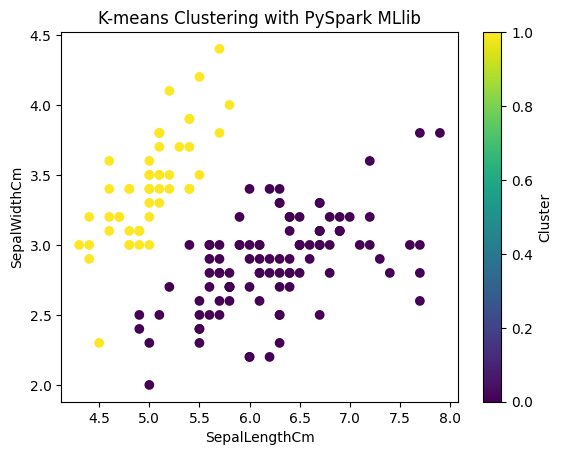

In [ ]:
# Converting to Pandas DataFrame
clustered_data_pd = clustered_data.toPandas()
# Visualizing the results
plt.scatter(clustered_data_pd["_c0"], clustered_data_pd["_c1"],c=clustered_data_pd["cluster"], cmap='viridis')
plt.xlabel("SepalLengthCm")
plt.ylabel("SepalWidthCm")
plt.title("K-means Clustering with PySpark MLlib")
plt.colorbar().set_label("Cluster")
plt.show()

In [ ]:
# for K values from 2 to 8
wssse_values =[]
evaluator = ClusteringEvaluator(predictionCol='prediction',featuresCol='scaled_features', metricName='silhouette',distanceMeasure='squaredEuclidean')
for i in range(2,11):
  KMeans_mod = KMeans(featuresCol='scaled_features', k=i)
  KMeans_fit = KMeans_mod.fit(data_df)
  output = KMeans_fit.transform(data_df)
  score = evaluator.evaluate(output)
  wssse_values.append(score)
  print("Silhouette Score:",score)

Silhouette Score: 0.7714149126311811
Silhouette Score: 0.6435633372614079
Silhouette Score: 0.5825498311859583
Silhouette Score: 0.5187417908593397
Silhouette Score: 0.5252242150380523
Silhouette Score: 0.5121552997744231
Silhouette Score: 0.4631683815886659
Silhouette Score: 0.4439635873488662
Silhouette Score: 0.4976491821296623


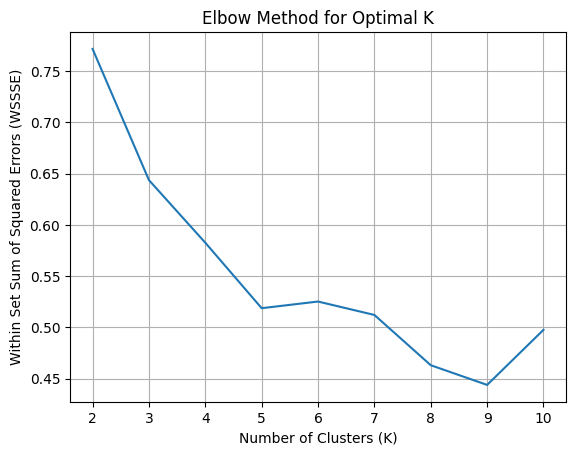

In [ ]:
# Plotting WSSSE values
plt.plot( range(2,11),wssse_values)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within Set Sum of Squared Errors (WSSSE)')
plt.title('Elbow Method for Optimal K')
plt.grid()
plt.show()